# P2P Lending Profit
<i> Authors: Markus Viljanen </i>

In this notebook, we explain how it is possible to predict the profits of censored peer-to-peer (P2P) loans. 

First, we illustrate the problem by visualizing monthly payments in loans. We use the standard approach in finance, known as the discounted cashflow (DCF) analysis, to calculate the profit from these payments. See for example https://en.wikipedia.org/wiki/Discounted_cash_flow. The problem therefore becomes to predict these payments.

We then describe the following models for this purpose:
1. Default model: predicts the monthly default rate of each loan.
2. Loss Given Default model: predicts the monthly recoveries in each loan if a loan defaults.
3. Profit model: uses the 'Default' and 'Loss Given Default' models to predict the monthly payments.

Given monthly loan payments $P_1, P_2, P_3, ...$, the DCF analysis calculates the present value of these payments given a monthly discount rate $i$:

$$ \text{PV}(i) = \sum_{t=1}^{\infty} \frac{P_t}{(1+i)^t}$$

Now if the loan amount is $M$, the monthly profit is simply the discount rate that makes the present value of monthly payments equal to the loan amount:

$$ M = \text{arg}_i \text{PV}(i)$$

The following code returns the profit given a vector of monthly payments, for example:

In [4]:
from scipy.optimize import bisect

def calculate_profit(cashflow):
    t = np.arange(len(cashflow)) + 1
    dcf = lambda i: (cashflow / (1 + i) ** t).sum() - 1
    profit_m = bisect(dcf, -0.999, 10.00, maxiter=3000) if dcf(-0.999) > 0 else -1.00
    profit_y = (1 + profit_m) ** 12 - 1
    return profit_y

## Imports

These are the standard imports, extra imports, and imports from our package:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from collections import OrderedDict
from sklearn.model_selection import ShuffleSplit
from ipywidgets import interact, interact_manual

In [18]:
from models import DefaultModel, LGDModel, ProfitModel
from visualizations import plot_payments, plot_models

## Data set

We use a publically available data set from Bondora (https://www.bondora.com/public-reports). 

The following code can be used to download and process the data (takes a while):

In [ ]:
from process_userhistory import process_start as process_1
from process_features import process_start as process_2
from process_output import process_start as process_3

print('Downloading...')
opener = request.build_opener()
opener.addheaders = [('User-agent', 'cashmoney')]
request.install_opener(opener)
request.urlretrieve('https://www.bondora.com/marketing/media/LoanData.zip', 'datas/LoanData.zip')
request.urlretrieve('https://www.bondora.com/marketing/media/RepaymentsData.zip', 'datas/RepaymentsData.zip')

print('Unzipping...')
with zipfile.ZipFile("datas/LoanData.zip", "r") as zip_ref: zip_ref.extractall("datas/")
with zipfile.ZipFile("datas/RepaymentsData.zip", "r") as zip_ref: zip_ref.extractall("datas/")

print('Processing...')
process_1(verbose=False) #LoanData.csv => UserHistories.csv
process_2(verbose=False) #LoanData.csv, UserHistories.csv => LoanData2.csv
process_3(verbose=False) #LoanData.csv, RepaymentsData.csv => df_Y.csv, df_R.csv, df_M.csv

The data set is processed into the following files: 
* LoanData2.csv
* df_Y.csv
* df_R.csv
* df_M.csv

The 'LoanData2.csv' file describes the loans. Each loan is identified by a 'LoanId' and additional columns that describe the features of that loan:

In [5]:
loans = pd.read_csv('datas/LoanData2.csv')
loans[['LoanId', 'Interest', 'Year', 'Rating', 'LoansToIncome']].head()

,LoanId,Interest,Year,Rating,LoansToIncome
0,66AE108B-532B-4BB3-BAB7-0019A46412C1,20.97,2016,C,1.412429
1,D152382E-A50D-46ED-8FF2-0053E0C86A70,17.12,2015,B,2.000000
2,87342E13-66CB-483F-833A-007953E50C78,13.67,2016,A,0.000000
3,87227056-6BF9-410C-98D1-008F788E122A,40.40,2015,F,0.000000
4,2DDE6336-E466-4624-A337-00A0ED1A1468,68.39,2015,HR,0.000000


The 'df_M.csv' file describes the monthly payments. We analyze the problem as if 1€ is invested in each loan to make the loans comparable. Each row describes the loan 'LoanId', month 'T', and monthly payment 'Y':

In [6]:
payments = pd.read_csv('datas/df_M.csv')
payments = loans[['LoanId', 'Amount']].merge(payments)
payments['Y'] = payments['M'] / payments['Amount']
payments[['LoanId', 'T', 'Y']].head()

,LoanId,T,Y
0,66AE108B-532B-4BB3-BAB7-0019A46412C1,1,0.038696
1,66AE108B-532B-4BB3-BAB7-0019A46412C1,2,0.027012
2,66AE108B-532B-4BB3-BAB7-0019A46412C1,3,0.027045
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,4,0.027049
4,66AE108B-532B-4BB3-BAB7-0019A46412C1,5,0.027002


The 'df_Y.csv' file describes the monthly defaults. We denote 0: 'loan did not default' and 1: 'loan defaulted' in each monthly interval up to the default (1) / repaid (0) / followup (0) time. Each row describes the loan 'LoanId', month 'T', and default indicator 'Y':

In [7]:
intervals = pd.read_csv('datas/df_Y.csv')
intervals[['LoanId', 'T', 'Y']].head()

,LoanId,T,Y
0,66AE108B-532B-4BB3-BAB7-0019A46412C1,1,0
1,66AE108B-532B-4BB3-BAB7-0019A46412C1,2,0
2,66AE108B-532B-4BB3-BAB7-0019A46412C1,3,0
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,4,0
4,66AE108B-532B-4BB3-BAB7-0019A46412C1,5,0


The 'df_R.csv' file describes the monthly recoveries in defaulted loans. We calculate the recoveries as percentage of remaining principal (Exposure at Default or EAD) recovered in each subsequent month after a default. Each row describes the loan 'LoanId', month 'T', and recovery percentage 'Y':

In [8]:
residuals = pd.read_csv('datas/df_R.csv')
residuals[['LoanId', 'T', 'Y']].head()

,LoanId,T,Y
0,66AE108B-532B-4BB3-BAB7-0019A46412C1,1,0.000000
1,66AE108B-532B-4BB3-BAB7-0019A46412C1,2,0.000000
2,66AE108B-532B-4BB3-BAB7-0019A46412C1,3,0.000000
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,4,0.046606
4,66AE108B-532B-4BB3-BAB7-0019A46412C1,5,0.000000


## Why is censoring a big problem?

### Example 1: Payments in non-censored loans

First, lets go way back and look at 100 random loans of 2 years duration that were made 10 years ago:

In [9]:
subset = loans.loc[(loans['LoanDuration'] == 24) & (loans['Year'] == 2010), 'LoanId']
subset = np.random.choice(subset, 100, replace=False)

We then visualize the data. It can be seen that many loans are repaid within the 2 years, but if a loan defaults and we extract recovery payments they can happen many years after. However, waiting for 10 years to gather a complete data set of payment histories seems probably sufficient in practise:

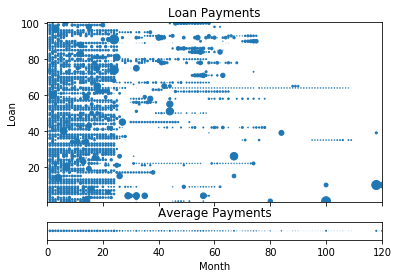

In [10]:
plot_payments(payments[payments['LoanId'].isin(subset)], followup=False)

The payments in each loan look like this:

In [11]:
cashflows = payments[payments['LoanId'].isin(subset)].pivot(index='LoanId', columns='T', values='Y')
cashflows.round(2).iloc[1:10,0:120]

T,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
LoanId,,,,,,,,,,,,,,,,,,,,,
0E63D66C-0963-485B-9C15-9E02009AB2C1,0.07,0.06,0.00,0.12,0.00,0.12,0.06,0.06,0.06,0.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
11134018-F3B9-465A-8737-9D590135DF0F,0.01,0.05,0.05,0.00,0.12,0.05,0.05,0.05,0.06,0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11AE9FBA-DA99-430C-A96D-9D460158C71B,0.06,0.05,0.05,0.05,0.05,0.05,0.80,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12E90CB0-B420-4C65-B8C6-9D1D01103508,0.06,0.10,0.05,0.01,0.05,0.05,0.05,0.05,0.06,0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17053D5D-02E4-48F8-A416-9D2200F79DF3,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1B34092E-1C67-42A4-AC72-9E5101806A08,0.09,0.06,0.00,0.12,0.00,0.12,0.06,0.00,0.12,0.06,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1B3FCB72-2D67-4B43-92E3-9DE3015ADFFA,0.00,0.11,0.05,0.05,0.04,0.02,0.00,0.01,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1B6F9FA2-D6D8-46B1-B3D4-9D5F00BB005F,0.07,0.06,0.06,0.06,0.06,0.06,0.01,0.11,0.00,0.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C9F4008-8AFA-4343-B4AA-9D1E00FAC8D0,0.03,0.09,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


If we invested in a portfolio of these loans, we get the mean payment:

In [12]:
mean_cashflow = cashflows.mean(axis=0)#payments_subset.groupby('T')['Y'].agg('mean')
pd.DataFrame(mean_cashflow).round(2).transpose().iloc[:,0:120]

T,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
0,0.06,0.06,0.05,0.05,0.04,0.06,0.05,0.04,0.04,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.01


Lets calculate the profit of each loan and the portfolio of such loans:

In [13]:
profits = pd.Series({loanid: calculate_profit(cashflow) for loanid, cashflow in cashflows.iterrows()})
mean_profit = calculate_profit(mean_cashflow)

We see that these loans had different profits and the overall profit is quite respectable 26% (in few loans made 10 years ago):

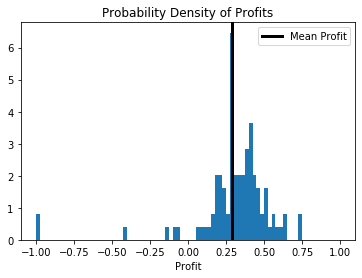

In [14]:
plt.figure()
plt.hist(profits, bins=np.arange(-1,1+0.025,0.025), density=True)
plt.axvline(mean_profit, color='black', linewidth=3, label='Mean Profit')
plt.title('Probability Density of Profits')
plt.xlabel('Profit')
plt.legend()

### Example 2

Second, lets look at 100 loans sampled randomly from the entire Bondora data set:

In [15]:
subset = np.random.choice(loans['LoanId'], 100, replace=False)

We visualize the data and also illustrate the follow-up of each loan. For example, if a loan was made 2019-01-01 and the data was gathered 2020-06-30, the loan should have 18 months of follow-up. We see that there is a serious problem: many loans have not been followed for long enough for their paymments to be observable, and the situation is worse the more recent or more longer duration the loans are: 

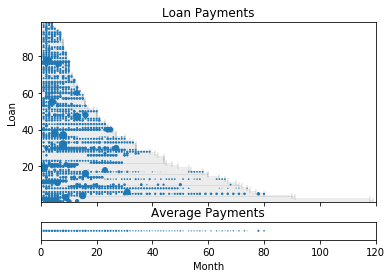

In [16]:
plot_payments(payments[payments['LoanId'].isin(subset)], followup=True)

These are the payments in individual loans, with the problem that many of them are now unknown:

In [17]:
cashflows = payments[payments['LoanId'].isin(subset)].pivot(index='LoanId', columns='T', values='Y')
cashflows.round(2).iloc[1:10,0:120]

T,1,2,3,4,5,6,7,8,9,10,...,110,111,112,113,114,115,116,117,118,119
LoanId,,,,,,,,,,,,,,,,,,,,,
01DABE36-564F-4402-A542-A704012B060C,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02E8A15F-5C6B-4C99-80F2-AA4C00A6DFC3,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0302908D-3EAA-4769-ADC4-9DC800F85FDA,0.01,0.21,0.10,0.10,0.10,0.10,0.08,0.03,0.00,0.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0934CD95-C832-4209-97FF-AB02012E4762,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100915B6-B974-4CD0-ADDF-A81E00DBE0EB,0.03,0.00,0.06,0.03,0.00,0.03,0.03,0.03,0.03,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015709E-A155-48D9-A1AB-A37D00A2799F,0.04,0.04,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11E6EFAD-89C9-41CD-9F36-A14300FE4868,0.03,0.00,0.04,0.04,0.04,0.08,0.00,0.06,0.02,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129DAF74-3E39-4BB2-8048-A46E0092A607,0.00,0.10,0.00,0.00,0.00,0.00,0.03,0.07,0.07,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14AA50C5-2B9E-46CF-8692-A674010B4C0A,0.11,0.00,0.11,0.11,0.11,0.11,0.03,0.00,0.30,0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


However, calculating the mean payment still works, as long as the payments are calculated over the observable loans (NaNs ignored):

In [18]:
mean_cashflow = cashflows.mean(axis=0)#payments_subset.groupby('T')['Y'].agg('mean')
pd.DataFrame(mean_cashflow).round(2).transpose().iloc[:,0:120]

T,1,2,3,4,5,6,7,8,9,10,...,110,111,112,113,114,115,116,117,118,119
0,0.04,0.05,0.04,0.04,0.04,0.04,0.02,0.05,0.03,0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets again try to calculate the profits. Now there is a serious problem: the DCF calculation assumes that unobserved payments are never made, so the profits are severely underestimated. If one assumes they will be made on schedule (so the loans never default), the profits would be severely overestimated. At least the 'mean profit' still works:

In [19]:
profits = pd.Series({loanid: calculate_profit(cashflow) for loanid, cashflow in cashflows.iterrows()})
mean_profit = calculate_profit(mean_cashflow)

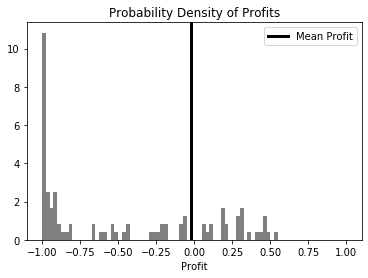

In [20]:
plt.figure()
plt.hist(profits, bins=np.arange(-1,1+0.025,0.025), density=True, color='grey')
plt.axvline(mean_profit, color='black', linewidth=3, label='Mean Profit')
plt.title('Probability Density of Profits')
plt.xlabel('Profit')
plt.legend()

Many loans now seem less profitable because they are missing payments. However, the profit calculation of a portfolio based on the mean payments was supposed to be accurate, but the profit seems to be around zero! (in a representative sample of all loans)

### Example 3

Could we somehow predict the mean payment in each loan? In a way that accounts for censoring?

The answer is yes, but we need to take into account the loan schedule. It was seen in the previous examples that the loan schedule has a huge effect on the obtained payments because most payments are made on schedule. However, loans default and we do not obtain the scheduled payments in full. We also obtain recovery payments after the loan duration is already over from the defaulted loans. 

To predict the payments, we cannot simply mathematically calculate the loan schedule and assume we get these payments. It is not smart to directly model the loan payments either, because the loan schedule is completely deterministic and significantly affects how the payments are going to look like. We therefore need a model between these two extremes: one that incorporates the loan schedule but also how defaults and recoveries affect it.

The following widget can be used to play around with the loan schedule. Each loan is defined by three variables:
1. Loan duration $n$ (months)
2. Loan amount $M$ (euros)
3. Interest rate $I$ (monthly) 

The scheduled monthly payments can then be calculated from the annuity formula $P = M I \frac{(1+I)^n}{(1+I)^n - 1} $. 

In [33]:
def calculate_payments(loan_duration=24, loan_amount=1000, interest_rate=12):
    interest_month = interest_rate/12/100
    payment = loan_amount * interest_month * (1 + interest_month)**loan_duration / ((1 + interest_month)**loan_duration - 1)
    payments = pd.Series(np.array([payment]*loan_duration + [0.0]*(80 - loan_duration)), index=np.arange(80) + 1)
    fig, ax = plt.subplots(1, 1)
    payments.plot(ax=ax, drawstyle='steps-post')
    ax.set_title('Loan Payments')
    ax.set_ylabel('Payment')
    ax.set_xlabel('Month')

_ = interact(calculate_payments, loan_duration=(12,60,12), loan_amount=(1000,10000,1000), interest_rate=(5,50,5))

interactive(children=(IntSlider(value=24, description='loan_duration', max=60, min=12, step=12), IntSlider(val…

Again, lets take 100 random loans for illustration:

In [21]:
ids = np.random.choice(loans['LoanId'], 100, replace=False)

We need to model how defaults and recoveries affect the loan schedule. The following visualization shows how the data set of payments can be split into two complementary data sets: one for defaults and another for recoveries:

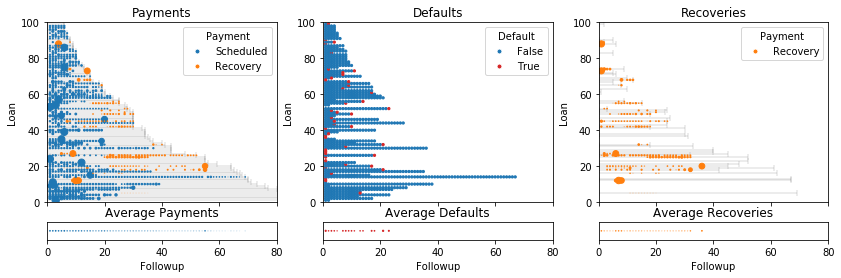

In [22]:
plot_models(payments[payments['LoanId'].isin(ids)],
            intervals[intervals['LoanId'].isin(ids)],
            residuals[residuals['LoanId'].isin(ids)])

While the loan has not defaulted we obtained a scheduled payment or an early repayment. After the loan defaults we obtain the recovery payments. For this reason, we are going to develop two models based on these data sets:
1. Default model: predicts the default (% probability) in each monthly interval
2. Loss Given Default model: predicts the recovery (% of EAD) in each monthly interval after a default

When we have models for the defaults and recoveries, we can calculate the monthly payments. Define the following quantities:
1. Payment rate: mean payment per month.
2. Default rate: mean number of defaults per month.
3. Recovery rate: mean recovery after a default per month.

The predicted default rate (Default model) and recovery rate (Loss Given Default model) imply the monthly payments (Profit model):

    'Default rate' + 'Recovery rate' = 'Payment rate'

We can actually calculate these rates in the data set without any model:

In [23]:
payment_rate = payments.groupby('T')['Y'].agg('mean')
default_rate = intervals.groupby('T')['Y'].agg('mean')
recovery_rate = residuals.groupby('T')['Y'].agg('mean')

(0, 80)

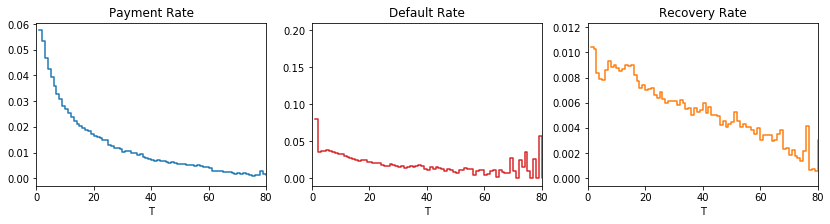

In [24]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(14,3))
payment_rate.plot(ax=ax1, drawstyle='steps-post', color='tab:blue').set_title('Payment Rate')
default_rate.plot(ax=ax2, drawstyle='steps-post', color='tab:red').set_title('Default Rate')
recovery_rate.plot(ax=ax3, drawstyle='steps-post', color='tab:orange').set_title('Recovery Rate')
ax1.set_xlim(0,80)

The payment rate is explained by the default rate and recovery rate. Many defaults occur immediately as around 8% of loans default the first month, 4% the second month, etc. until over time a default becomes less and less likely as the loan has survived and made more scheduled payments. It can be seen that if a loan defaults around 1% or principal is recovered the first month, and this looks like tends to 0% recovery linearly over about 100 months. This implies that around $1\%*100/2 = 50\%$ of principal is recovered over time, on average. 

If one invested 1€ in all historical Bondora loans equally, on average one would obtain about 0.058€ back the first month,  0.055€ the second month, etc. until at 80 months practically 0.000€ is obtained. It is possible to calculate the profit of this portfolio from the payments, and see that it is indeed a lot lower than the historical loans or statistics suggest:

In [25]:
print("Profit of all Bondora loans: %.2f %%" % (calculate_profit(payment_rate) * 100))

Profit of all Bondora loans: 0.75 %


### Default Model

The first model is the default model. The model describes the default event $Y_{i,t}$ of loan $i$ at time $t$ as a logistic regression model, which is a discrete time analogue of the popular Cox proportional hazards model. Given time indicator vector $e_t$ and loan feature vector $x_i$, we seek model parameter vectors $\alpha, \beta$ such that:

$$ \frac{P(Y_{i,t} = 1)}{1 - P(Y_{i,t} = 1)} = \text{exp}(\alpha^T e_t + \beta^T x_i) $$ 

In the Python implmentation, we use scikit-learn that penalizes the parameter vectors by Tikhonov regularization.

For this model, we load the loan features and default events:

In [26]:
loans = pd.read_csv('datas/LoanData2.csv')
intervals = pd.read_csv('datas/df_Y.csv')

In this example we fit the model to 10 000 random loans and analyze the default rate up to 80 months:

In [27]:
loanids = np.random.choice(loans['LoanId'], 10000, replace=False)
loans = loans[loans['LoanId'].isin(loanids)]
intervals = intervals[(intervals['T'] <= 80) & (intervals['LoanId'].isin(loanids))]

The following constructs the model. We define which columns should be numeric and which categorical (one-hot encoded). The time variable can be either numeric or categorical (T_classes=...), which correspond to a type parametric or non-parametric method:

In [28]:
col_numeric = ['Interest', 'Age', 'ApplicationSignedHour', 'ApplicationSignedWeekday', 'LoanDuration', 'Amount',
                  'IncomeTotal', 'LiabilitiesTotal', 'LiabilitiesToIncome', 'LoansToIncome', 'PaymentToIncome',
                  'ExistingLiabilities', 'PreviousNumber_Intervals', 'PreviousNumber', 'PreviousNumber_Current',
                  'PreviousNumber_Default', 'PreviousNumber_Repaid', 'PreviousNumber_Rescheduled']
col_classes = ['Year', 'Rating', 'Rating2', 'Gender', 'Education', 'HomeOwnershipType',
                  'EmploymentDurationCurrentEmployer', 'VerificationType', 'LiabilitiesToIncomeUnknown', 'NoHistory']
all_classes = OrderedDict([(col, np.sort(loans[col].unique())) for col in col_classes])
#T_classes = np.sort(intervals['T'].unique())

model = DefaultModel(col_numeric, col_classes, all_classes)#, T_classes=T_classes)


Lets fit the model and calculate the AUC. The stratified AUC takes into account that different samples may come from the same loan:

In [29]:
model.fit(loans, intervals)
P = model.predict(loans, intervals)
Y = intervals['Y']
T = intervals['T']
print(model.auc(Y, P), model.auc_stratified(Y, P, T))

0.7311076332271493 0.7384438925097107


We can also plot the AUC by each month, meaning how well the model predicts defaults that month:

Text(0.5, 1.0, 'AUC Time-Varying')

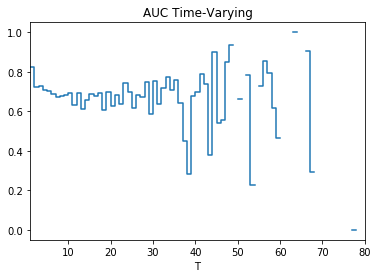

In [30]:
aucs = model.auc_t(Y, P, T)
pd.Series(aucs).plot(drawstyle='steps-post').set_title('AUC Time-Varying')

We can also interpret the coefficients of the model, which are quite intuitive. Higher default rate is predicted by higher interest rate, lower age, higher debt load, lower credit rating, less past payments, etc:

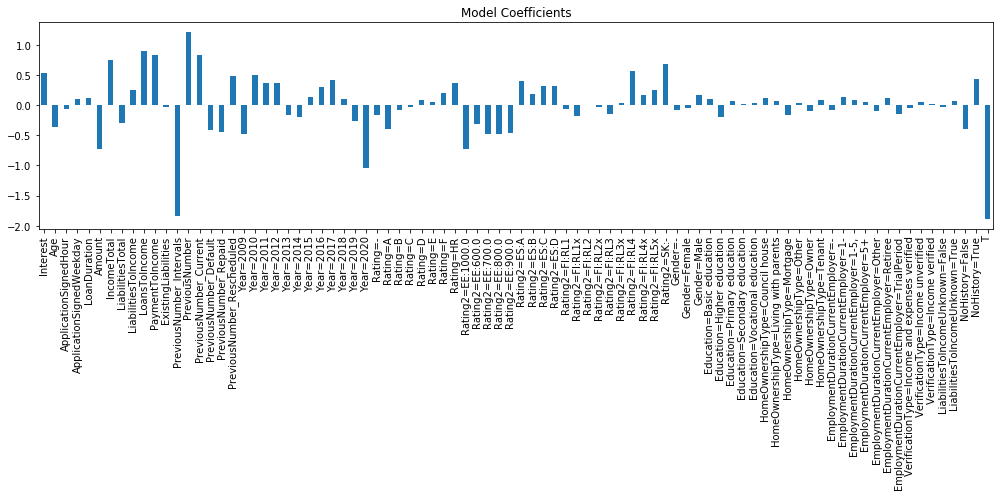

In [31]:
coefs = model.coefs()
coefs.plot(kind='bar').set_title('Model Coefficients')
plt.gcf().set_size_inches(14, 7)
plt.tight_layout()

Finally, we split the data into training and test sets. The linear model is not very prone to overfitting and almost equal AUC is obtained:

In [32]:
gkf = ShuffleSplit(n_splits=1, test_size=0.2)
train, test = next(gkf.split(loans))
train_loans, test_loans = loans.iloc[train,], loans.iloc[test,]
train_intervals, test_intervals = train_loans[['LoanId']].merge(intervals), test_loans[['LoanId']].merge(intervals)
model.fit(train_loans, train_intervals)
P = model.predict(test_loans, test_intervals)
Y = test_intervals['Y']
T = test_intervals['T']
auc = model.auc_stratified(Y, P, T)
aucs = model.auc_t(Y, P, T)
print(auc)

0.7360142919198037


Text(0.5, 1.0, 'AUC Time-Varying')

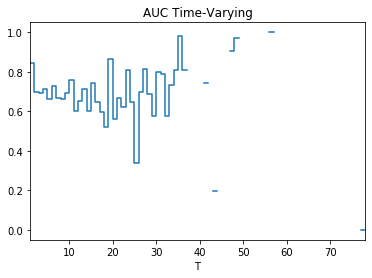

In [33]:
pd.Series(aucs).plot(drawstyle='steps-post').set_title('AUC Time-Varying')

This model can be used not only to predict the default probability each month, but also give a 'credit rating' to each borrower. Consider the odds ratio predicted by $ \frac{P(Y_{i,t} = 1)}{1 - P(Y_{i,t} = 1)} = \text{exp}(\alpha^T e_t + \beta^T x_i)$. In this expression, the term $\alpha^T e_t$ is an intercept that specifies the baseline default rate at month $t$, and the term $\beta^T x_i$ is the relative risk that specifies how loan $i$ affects the baseline default rate. 

We can therefore use therelative risk $\beta^T x_i$ term as the 'credit rating':

Text(0.5, 1.0, 'Relative Credit Risk score')

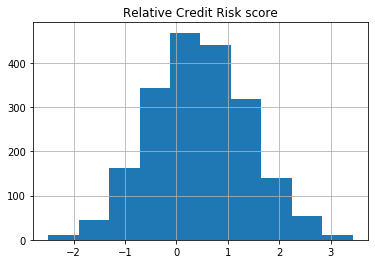

In [34]:
risk = model.risk(test_loans)
risk.hist().set_title('Relative Credit Risk score')

The relative risk is nicely normally distributed, and we could define high or low risk categories based on this.

## Loss Given Default Model

The second model is the loss given default model. The model describes the recovery $Y_{i,t}$ of loan $i$ at time $t$ as a least squares regression model. Given time indicator vector $e_t$ and loan feature vector $x_i$, we seek model parameter vectors $\alpha, \beta$ such that the expected recovery is described by:

$$ E[Y_{i,t}] = \text{exp}(\alpha^T e_t + \beta^T x_i) $$ 

In the Python implmentation, the 'log-link' is not available and we use scikit-learn that uses the following formulation and penalizes the parameter vectors by Tikhonov regularization:

$$ E[Y_{i,t}] = \alpha^T e_t + \beta^T x_i $$ 

For this model, we load the loan features and monthly recoveries:

In [35]:
loans = pd.read_csv('datas/LoanData2.csv')
residuals = pd.read_csv('datas/df_R.csv')

In this example we again fit the model to 10 000 random loans and analyze the recovery rate up to 80 months:

In [36]:
loanids = np.random.choice(loans['LoanId'], 10000, replace=False)
loans = loans[loans['LoanId'].isin(loanids)]
residuals = residuals[(residuals['T'] <= 80) & residuals['LoanId'].isin(loanids)]

The following constructs the model. We define which columns should be numeric and which categorical (one-hot encoded). The time variable can be either numeric or categorical (T_classes=...), which correspond to a type parametric or non-parametric method:


In [37]:
col_numeric = ['Interest', 'Age', 'ApplicationSignedHour', 'ApplicationSignedWeekday', 'LoanDuration', 'Amount',
                  'IncomeTotal', 'LiabilitiesTotal', 'LiabilitiesToIncome', 'LoansToIncome', 'PaymentToIncome',
                  'ExistingLiabilities', 'PreviousNumber_Intervals', 'PreviousNumber', 'PreviousNumber_Current',
                  'PreviousNumber_Default', 'PreviousNumber_Repaid', 'PreviousNumber_Rescheduled']
col_classes = ['Year', 'Rating', 'Rating2', 'Gender', 'Education', 'HomeOwnershipType',
                  'EmploymentDurationCurrentEmployer', 'VerificationType', 'LiabilitiesToIncomeUnknown', 'NoHistory']
all_classes = OrderedDict([(col, np.sort(loans[col].unique())) for col in col_classes])
#T_classes = np.sort(residuals['T'].unique())

model = LGDModel(col_numeric, col_classes, all_classes)#, T_classes=T_classes)

Lets fit the model and calculate the MSE. The MSE is very small because the absolute quantities (recoveries) are very small:

In [38]:
model.fit(loans, residuals)
P = model.predict(loans, residuals)
Y = residuals['Y']
T = residuals['T']
print(model.mse(Y, P))

0.0026983950267068712


We can also plot the MSE by each month, meaning how well the model predicts defaults that month. The task is easier when there are few recoveries:

Text(0.5, 1.0, 'MSE Time-Varying')

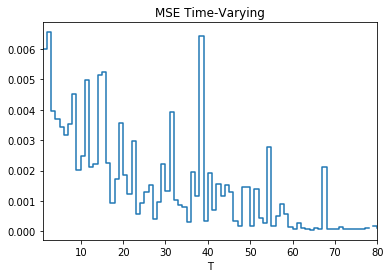

In [39]:
mses = model.mse_t(Y, P, T)
pd.Series(mses).plot(drawstyle='steps-post').set_title('MSE Time-Varying')

We can also interpret the coefficients of the model, which are again quite intuitive but different from the loss given default model. Note that whereas higher coefficients implied higher default probability, here higher coefficients imply higher recoveries. Lower recovery rate is predicted by higher age, higher loan amounts, higher debt load, more recent loan year, etc:


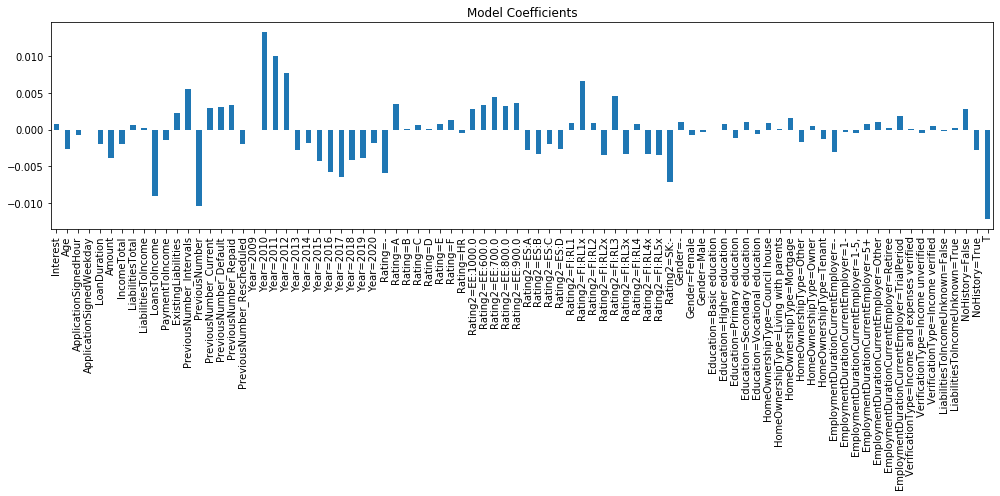

In [40]:
coefs = model.coefs()
coefs.plot(kind='bar').set_title('Model Coefficients')
plt.gcf().set_size_inches(14, 7)
plt.tight_layout()

Finally, we split the data into training and test sets. Somewhat larger MSE is obtained in the test set:

In [41]:
gkf = ShuffleSplit(n_splits=1, test_size=0.2)
train, test = next(gkf.split(loans))
train_loans, test_loans = loans.iloc[train,], loans.iloc[test,]
train_residuals, test_residuals = train_loans[['LoanId']].merge(residuals), test_loans[['LoanId']].merge(residuals)
model.fit(train_loans, train_residuals, C=1)
P = model.predict(test_loans, test_residuals)
Y = test_residuals['Y']
T = test_residuals['T']
mse = model.mse(Y, P)
mses = model.mse_t(Y, P, T)
print(mse)

0.0030392788540646648


Text(0.5, 1.0, 'MSE Time-Varying')

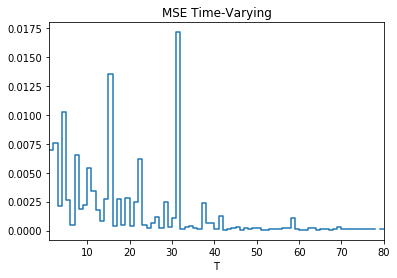

In [42]:
pd.Series(mses).plot(drawstyle='steps-post').set_title('MSE Time-Varying')

This model can be used not only to predict the recovery rate each month, but also calculate the Loss Given Default (LGD) of each loan. For this, we predict the monthly recoveries and calculate the present value of the payments using a discount rate of 10%, for example. This gives the following results:

Text(0.5, 1.0, 'Loss Given Default')

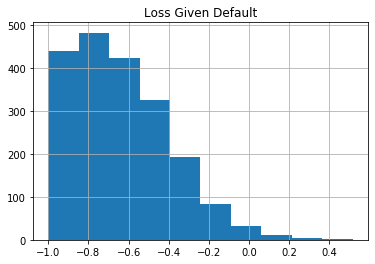

In [43]:
lgds = model.lgd(test_loans)
lgds.hist().set_title('Loss Given Default')

It seems like very high predicted losses are common if we take into account the 'time value of money'. In few cases, the predicted loss can be positive if all principal is recovered with interest.

## Profit Model

Finally, the above models are combined in the profit model. We first predict the default rate and recovery rate of each loan, then calculate the monthly payments that are implied by these rates. Then we calculate the profit from these monthly payments.

This model requires the loan features, default events, and recoveries:

In [44]:
loans = pd.read_csv('datas/LoanData2.csv')
intervals = pd.read_csv('datas/df_Y.csv')
residuals = pd.read_csv('datas/df_R.csv')

In the last example, we use a random set of 20 000 loans up to 80 monthly intervals:

In [45]:
loanids = np.random.choice(loans['LoanId'], 20000, replace=False)
loans = loans[loans['LoanId'].isin(loanids)]
intervals = intervals[(intervals['T'] <= 80) & (intervals['LoanId'].isin(loanids))]
residuals = residuals[(residuals['T'] <= 80) & (residuals['LoanId'].isin(loanids))]

The following constructs the model, which is basically the 'Default' model and 'Loss Given Default' model wrapped inside a class with special mathematical calculations for the payments:

In [46]:
col_numeric = ['Interest', 'Age', 'ApplicationSignedHour', 'ApplicationSignedWeekday', 'LoanDuration', 'Amount',
                  'IncomeTotal', 'LiabilitiesTotal', 'LiabilitiesToIncome', 'LoansToIncome', 'PaymentToIncome',
                  'ExistingLiabilities', 'PreviousNumber_Intervals', 'PreviousNumber', 'PreviousNumber_Current',
                  'PreviousNumber_Default', 'PreviousNumber_Repaid', 'PreviousNumber_Rescheduled']
col_classes = ['Year', 'Rating', 'Rating2', 'Gender', 'Education', 'HomeOwnershipType',
                  'EmploymentDurationCurrentEmployer', 'VerificationType', 'LiabilitiesToIncomeUnknown', 'NoHistory']
all_classes = OrderedDict([(col, np.sort(loans[col].unique())) for col in col_classes])
T_classes = np.sort(intervals['T'].unique())

model = ProfitModel(col_numeric, col_classes, all_classes, T_classes)


The model can be used to predict payments in on-going loans, so we need to define that these loans are just issued:

In [47]:
loans['Interest'] = loans['Interest'] / 12.0 / 100
loans['n_survived'] = 0
loans['n_total'] = loans['LoanDuration']

Lets divide the data into a training set and test set:

In [48]:
gkf = ShuffleSplit(n_splits=1, test_size=0.2)
train, test = next(gkf.split(loans))
train_loans, test_loans = loans.iloc[train,], loans.iloc[test,]
train_intervals = train_loans[['LoanId']].merge(intervals)
test_intervals = test_loans[['LoanId']].merge(intervals)
train_residuals = train_loans[['LoanId']].merge(residuals)
test_residuals = test_loans[['LoanId']].merge(residuals)
model.fit(train_loans, train_intervals, train_residuals, C1=1, C2=1)

We can now predict the cashflows in each loan in the test set:

In [50]:
cashflows = model.predict_cashflow(test_loans, t=80)
cashflows.round(2).iloc[1:10,0:120]

,1,2,3,4,5,6,7,8,9,10,...,71,72,73,74,75,76,77,78,79,80
BF068A6F-2A69-48EA-9567-A2B20171AA70,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CFBF6988-78E3-4AAC-8F92-A9200103F08E,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.03,0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F1A598D2-24E7-451E-AD50-A5D80100AB67,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2625634-A362-4B35-84B1-A862009A13AB,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299314EF-5E0D-46CB-BF41-AA9900803019,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B37583E6-FCD4-4E6F-B370-AB0901610EC4,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
791868D9-E06C-4B66-B1F3-A6DE01302621,0.08,0.06,0.05,0.04,0.03,0.02,0.02,0.02,0.01,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9642DCBB-D74F-4B25-A7A6-A9830067EAB1,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA5BECB3-305C-4B4A-8A23-A69E00E50C83,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From these cashflows, it is straightforward to calculate the implied profit:

In [52]:
profits = model.predict_profit(cashflows)
profits.iloc[1:10]

BF068A6F-2A69-48EA-9567-A2B20171AA70    21.368364
CFBF6988-78E3-4AAC-8F92-A9200103F08E    16.021316
F1A598D2-24E7-451E-AD50-A5D80100AB67     4.875499
C2625634-A362-4B35-84B1-A862009A13AB    -6.721435
299314EF-5E0D-46CB-BF41-AA9900803019    30.943259
B37583E6-FCD4-4E6F-B370-AB0901610EC4   -23.903335
791868D9-E06C-4B66-B1F3-A6DE01302621   -63.335821
9642DCBB-D74F-4B25-A7A6-A9830067EAB1    23.543252
AA5BECB3-305C-4B4A-8A23-A69E00E50C83   -21.996841
dtype: float64

the model predicts that some loans have very high losses and some appear to have quite large profits. The predicted profits appear reasonable with around 5% yearly profits being the most common:

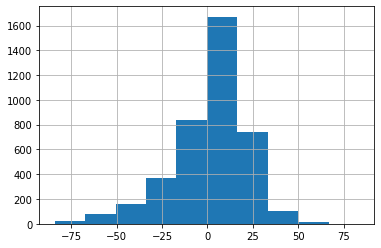

In [53]:
profits.hist()

To test the ability of the model to outperform the market, we divide each test set loan into ten quantiles (1,2, ..., 10) based on the predicted profit. Each quantile defines a portfolio of loans, and we calculate the actual mean payment and the resulting profit in each portfolio:

In [54]:
quantiles = pd.Series(pd.qcut(profits, 10, labels=np.arange(10) + 1), index=profits.index)
quantile_predicted = cashflows.groupby(quantiles).mean()

In [55]:
test_loans['Quantile'] = test_loans['LoanId'].map(quantiles)
outcomes = pd.read_csv('datas/df_M.csv')
outcomes = test_loans[['LoanId', 'Amount', 'Quantile']].merge(outcomes)
outcomes['Y'] = outcomes['M'] / outcomes['Amount']
quantile_actual = outcomes.groupby(['Quantile', 'T'])['Y'].mean().unstack(level=1, fill_value=0.0)

C:\Users\mvil4\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The loans that are predicted to be the most profitable indeed had the highest profits in reality. However, the actual magnitude of profits is not as high as predicted by the model. It looks like picking the loans in the top 3 quantiles is the only way to make any profit at all:

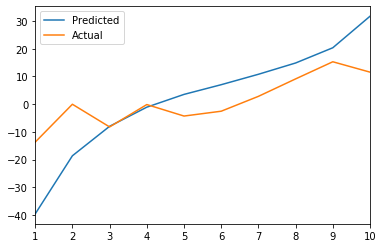

In [56]:
quantile_profits = pd.DataFrame({'Predicted': model.predict_profit(quantile_predicted),
                                 'Actual': model.predict_profit(quantile_actual)})
quantile_profits.plot()

We can also compare the actual cashflows predicted by the model and received from the test set loans. It looks like the real world does not operate as smoothly as the model assumes, but the relative order of the quantiles is quite nicely predicted:

(0, 80)

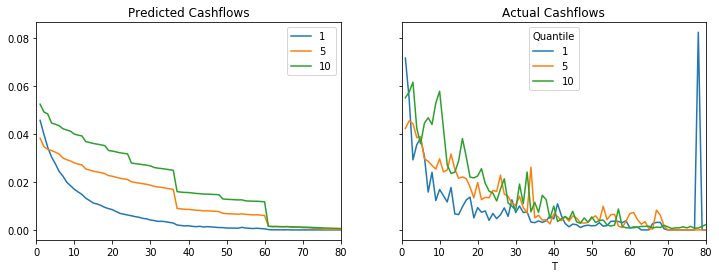

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12,4))
quantile_predicted.transpose()[[1, 5, 10]].plot(ax=ax1).set_title('Predicted Cashflows')
quantile_actual.transpose()[[1, 5, 10]].plot(ax=ax2).set_title('Actual Cashflows')
ax1.set_xlim(0,80)

Finally, the following widget can be used to visualize the predicted cashflow, default rate, and recovery rate:

In [59]:
features = OrderedDict()

for col in train_loans.columns:
    if col in col_classes:
        features[col] = list(np.sort(train_loans[col].unique()))
        
for col in train_loans.columns:
    if col in col_numeric:
        low, high = train_loans[col].min(), train_loans[col].max()
        step = (high - low) / 20
        features[col] = (low, high, step)

def create_loan(**args):
    loan = pd.DataFrame(args, index=[0])
    loan['LoanId'] = 'new'
    loan['n_survived'] = 0
    loan['n_total'] = loan['LoanDuration']
    haz = model.predict(loan, t=80, classify=True)
    lgd = model.predict(loan, t=80, classify=False)
    cashflow = model.predict_cashflow(loan, t=80)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,3))
    cashflow.transpose().plot(ax=ax1, drawstyle='steps-post', color='tab:blue')
    haz.transpose().plot(ax=ax2, drawstyle='steps-post', color='tab:red')
    lgd.transpose().plot(ax=ax3, drawstyle='steps-post', color='tab:orange')
    ax1.set_title('Profit %.1f %%' % model.predict_profit(cashflow))
    ax2.set_title('Credit Risk Quantile %.1f %%' % (model.credit_risk(loan)*100))
    ax3.set_title('Loss Given Default %.1f %%' % (model.loss_given_default(loan)*100))
    ax1.set_ylabel('Payment Rate')
    ax2.set_ylabel('Default Rate')
    ax3.set_ylabel('Recovery Rate')
    ax1.set_ylim(0.00, 0.20)
    ax2.set_ylim(0.00, 0.16)
    ax3.set_ylim(0.00, 0.04)
    plt.tight_layout()
    
interact_manual(create_loan, **features)

interactive(children=(Dropdown(description='Year', options=(2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 20…

<function __main__.create_loan(**args)>

## Buy secondary loans 

We have a model that appears to outperform the market. Now what? Lets buy some loans!

Bondora provides an API (https://api.bondora.com/) to buy loans from the primary market where loans are made and the secondary market where investors can sell and purchase their loans. The following helper functions can be used for this purpose:

In [77]:
from market import train_model, get_data, get_primary, get_secondary, buy_secondary

Lets train a model:

In [78]:
model = train_model()

Reading...
Filtering...
Loans: 20000
Intervals: 211976
Residuals: 160893
Training...


The data set needs to be updated to include the most recent loans:

In [79]:
loans = get_data(download=False)
loans['LoanDate'] = pd.to_datetime(loans['LoanDate'])
loans['Defaulted'] = ~loans['DefaultDate'].isnull()

Reading...


C:\Users\mvil4\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


149853
Adding user histories...
149839
Processing...
149839


One needs to authenticate with their Bondora account to access the API (see for example https://apimeister.com/2016/03/08/authenticate-with-bondora-API-manually.html). Now the following code gets some loans from the secondary market:   

In [80]:
auth = '8242UDT4z9JXeVsdQwvck7mNEwB0WR8yU5lc72EMwqd2shZc'
# Loan slices
slices = get_secondary(authorization=auth, download=False) #listedon_from='2020-08-01', listedon_to='2020-08-14'
print("Slices:", len(slices))
# Add LoanId and default status to slices
slices = slices.merge(loans[['UserName', 'LoanDate', 'Amount', 'Interest', 'LoanId', 'Status', 'Defaulted']])
print(len(slices))
# LoanData <=> Secondary market id match
ids1 = set(loans['LoanId'].unique())
ids2 = set(slices['LoanId'].unique())
print("(", len(ids1.difference(ids2)), "(", len(ids1.intersection(ids2)), ")", len(ids2.difference(ids1)), ")")

2020-08-17 2020-08-18
Slices: 5000
4850
( 147283 ( 2556 ) 0 )


These loan slices in the secondary market belong to the following loans:

In [81]:
loans['Interest'] = loans['Interest'] / 12.0 / 100
loans = loans.merge(slices[['LoanId', 'n_survived', 'n_total']].drop_duplicates())
print("Predict loans:", len(loans))

Predict loans: 2556


We predict their cashflows:

In [82]:
cashflow = model.predict_cashflow(loans)
risk = model.credit_risk(loans)

C:\Users\mvil4\Anaconda3\lib\site-packages\pandas\core\dtypes\dtypes.py:458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


Then it is simple to calculate the profit of each slice, which also depends on the premium the slice is sold at:

In [97]:
slices_cashflow = slices.set_index('LoanId')[[]].merge(cashflow, left_index=True, right_index=True)
slices_cashflow.index = slices.index

slices['Premium'] = (slices['Price'] / slices['PrincipalRemaining'])
slices['Profit'] = model.predict_profit(slices_cashflow.div(slices['Premium'], axis=0))
slices['Risk'] = slices['LoanId'].map(risk)

Lets map the slices into 10 quantilies by the predicted profit and calculate the mean profit in each:

In [98]:
slices = slices[(slices['LateAmountTotal'] == 0) & (slices['Status'] == 'Current') & ~slices['Defaulted']]
slices['Quantile'] = pd.qcut(slices['Profit'], 10, labels=np.arange(10) + 1, duplicates='raise')
print(slices.groupby('Quantile')['Profit'].mean())


Quantile
1    -12.444899
2     -0.288888
3      5.812622
4      9.243138
5     12.779887
6     16.573398
7     19.701682
8     23.326877
9     27.460353
10    35.148980
Name: Profit, dtype: float64


We visualize the predicted profit, the premium to principal, and the credit risk quantile. It looks like the secondary market loans that have not defaulted are very profitable, but are always sold at a premium and typically have a very high credit risk:

Text(0.5, 1.0, 'Credit Risk Quantile')

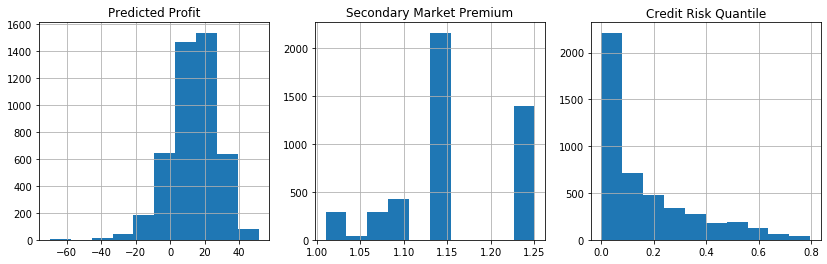

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
slices['Profit'].hist(ax=ax1).set_title('Predicted Profit')
slices['Premium'].hist(ax=ax2).set_title('Secondary Market Premium')
slices['Risk'].hist(ax=ax3).set_title('Credit Risk Quantile')

The most profitable slices look like this:

In [100]:
slices = slices.sort_values('Profit', ascending=False)
slices[['Price', 'Risk', 'Premium', 'Profit']].head()

,Price,Risk,Premium,Profit
2469,4.494573,0.163110,1.01,51.360436
2753,4.653048,0.096434,1.02,49.481092
3334,7.896716,0.080575,1.01,48.770125
2667,4.552955,0.132111,1.06,47.884419
2668,4.552955,0.132111,1.06,47.884419


Lets take the Ids of those slices with over 20% profit, which there are quite many

In [101]:
ids = slices.loc[slices['Profit'] > 20, 'Id']
print(len(ids))

1593


Now, it would be quite simple to buy these slices :-]

In [71]:
#for id in ids:
#    buy = {'ItemIds': [id]}
#    buy_secondary(auth, json.dumps(buy))
#    time.sleep(1.1)